In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
import statsmodels.api as sm
import pylab
import scipy.stats as stats

C:\Users\Aditya\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
data = pd.read_pickle("Cleandata.pkl")

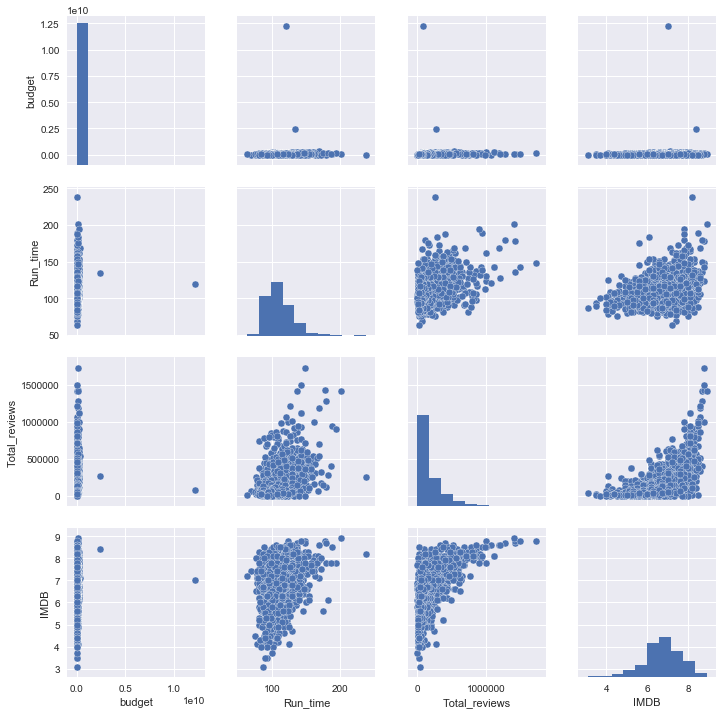

In [5]:
data_wo_category = data[["budget","Run_time","Total_reviews","IMDB"]]
sns.pairplot(data_wo_category)

Budget column has some outliers and Total reviews has some logarithm trend. Transforming data in that manner

In [6]:
data = data[data["budget"]<2.38e08]
data = data[data["Run_time"]<164]
data["Total_reviews"] = np.log(data["Total_reviews"])

In [7]:
y= data["IMDB"]
X = data.drop(["IMDB",'Movie'],axis=1)

In [8]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3)

In [9]:
impute_median = X_train["budget"].median()

In [10]:
X_train["budget"] = X_train["budget"].replace(0, impute_median)
X_test['budget'] = X_test["budget"].replace(0,impute_median)

C:\Users\Aditya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Aditya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
lr = LinearRegression()
lr.fit(X_train,y_train)
prediction = lr.predict(X_test)

In [12]:
print(mean_squared_error(y_test,prediction))
print(r2_score(y_test,prediction))

0.450009921052761
0.4351614036713226


Standardizing the data for Regularization

In [13]:
ssx = StandardScaler()
ssx.fit(X_train)
X_train_scaled = ssx.transform(X_train)
X_test_scaled =ssx.transform(X_test)

### Lasso

In [14]:
model = Lasso()
### The alpha value was pinpointed after getting the best value from best params
parameters =  {'alpha': np.linspace(1e-4,1e-3,50)}  
grid = GridSearchCV(model,parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': array([0.0001 , 0.00012, 0.00014, 0.00016, 0.00017, 0.00019, 0.00021,
       0.00023, 0.00025, 0.00027, 0.00028, 0.0003 , 0.00032, 0.00034,
       0.00036, 0.00038, 0.00039, 0.00041, 0.00043, 0.00045, 0.00047,
       0.00049, 0.0005 , 0.00052, 0.00054, 0.00056, 0.00058, 0.0006 ,...83, 0.00085,
       0.00087, 0.00089, 0.00091, 0.00093, 0.00094, 0.00096, 0.00098,
       0.001  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [15]:
grid.best_score_

-0.446618694276041

In [16]:
grid.best_params_

{'alpha': 0.000779591836734694}

In [17]:
best_lasso = grid.best_estimator_
lasso_pred = best_lasso.predict(X_test_scaled)
print(mean_squared_error(y_test, lasso_pred))
print(r2_score(y_test, lasso_pred))

0.45001266831711495
0.4351579553896985


Text(0.5,1,'Residual vs Predicted')

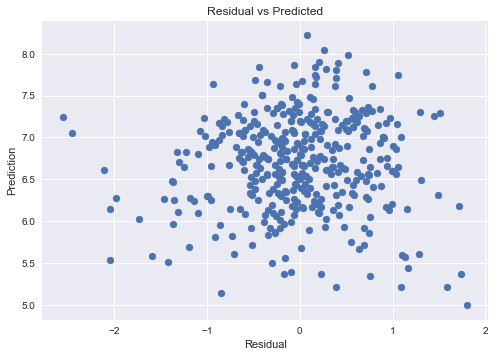

In [18]:
plt.scatter((y_test-lasso_pred), lasso_pred)
plt.xlabel("Residual")
plt.ylabel("Prediction")
plt.title("Residual vs Predicted")

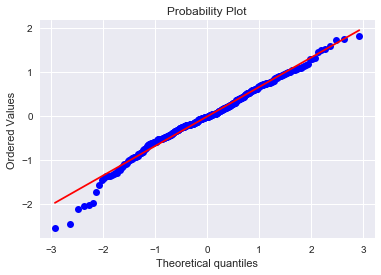

In [20]:
stats.probplot((y_test-lasso_pred), dist="norm", plot=pylab)
pylab.show()

### Ridge

In [21]:
model = Ridge()
parameters = {'alpha': np.linspace(12,14,100)}
grid_ridge = GridSearchCV(model,parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': array([12.    , 12.0202, ..., 13.9798, 14.    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [22]:
grid_ridge.best_score_

-0.44619018725193604

In [23]:
grid_ridge.best_params_

{'alpha': 14.0}

In [24]:
best_ridge = grid_ridge.best_estimator_
ridge_pred = best_ridge.predict(X_test_scaled)
print(mean_squared_error(y_test, ridge_pred))
print(r2_score(y_test, ridge_pred))

0.4504431136632606
0.4346176736453664


Text(0.5,1,'Lasso vs Ridge vs OLS')

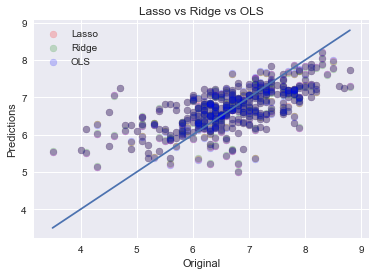

In [25]:
plt.scatter(y_test, lasso_pred, label="Lasso", c='r', alpha=0.2)
plt.scatter(y_test, ridge_pred, label="Ridge", c='g', alpha=0.2)
plt.scatter(y_test, prediction, label="OLS", c= 'b', alpha=0.2)
plt.plot([min(y_test), max(y_test)],[min(y_test), max(y_test)])
plt.legend(loc="upper left")
plt.xlabel("Original")
plt.ylabel("Predictions")
plt.title("Lasso vs Ridge vs OLS")

Text(0,0.5,'Predicted')

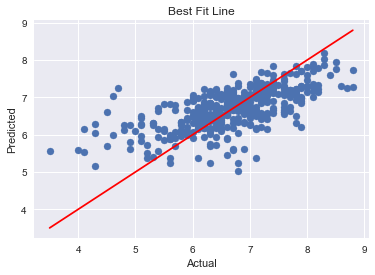

In [26]:
plt.scatter(y_test, ridge_pred)
plt.plot([min(y_test), max(y_test)],[min(y_test), max(y_test)], c= 'r')
plt.title("Best Fit Line")
plt.xlabel("Actual")
plt.ylabel("Predicted")